<a href="https://colab.research.google.com/github/aklekowski/agh-mpr/blob/main/OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [MPR] OpenMP - sortowanie kubełkowe

**Adam Klekowski, Paweł Kruczkiewicz**

In [122]:
import pandas as pd
import matplotlib as plt

## A. Opis algorytmów równoległych

### Algorytm 1 (Paweł Kruczkiewicz)
Implementacja w pliku [`bucket_sort_par_1.c`](https://github.com/pkrucz00/parallel-programming/blob/openmp/openmp/lab2/bucket_sort_par_1.c).

1. Czy potrzebna jest jakaś ochrona danych wspólnych (tablica początkowa: przy odczycie i przy zapisie; kubełki: przy zapisie, sortowaniu  kubełka, odczycie)?

Nie potrzebna jest synchronizacja.

2. Jaki jest rząd złożoności obliczeniowej algorytmu, a jaka jest praca algorytmu równoległego, czy algorytm jest sekwencyjnie-efektywny?

Rząd złożoności `O(N*P)`.

### Algorytm 2 (Adam Klekowski)
Implementacja w pliku [`bucket_sort_par_2.c`](https://github.com/aklekowski/agh-mpr/blob/main/src/bucket_sort_par_2.c).

1. Czy potrzebna jest jakaś ochrona danych wspólnych (tablica początkowa: przy odczycie i przy zapisie; kubełki: przy zapisie, sortowaniu  kubełka, odczycie)?

Ochrona pamięci potrzebna jest jedynie podczas zapisu do kubełków.

2. Jaki jest rząd złożoności obliczeniowej algorytmu, a jaka jest praca algorytmu równoległego, czy algorytm jest sekwencyjnie-efektywny?

Rząd złożoności `O(...)`.

## B. Badanie algorytmu sekwencyjnego
### B1. Dobór wielkości kubełka
Pomiarów dokonano na maszynie Ares na 1 rdzeniu procesora.
Wykonano po 20 pomiarów dla różnych wielkości problemu (10 000, 100 000, 1 000 000, 10 000 000) i rozmiarów koszyka (10, 100, 1 000, 10 000). Wyniki dla każdej konfiguracji uśredniono.

In [123]:
bucket_sort_df = pd.read_csv("bucket_sort_ver_1.csv")
bucket_sort_df = bucket_sort_df.loc[bucket_sort_df['P'] == 1]
bucket_sort_df = bucket_sort_df[['N', 'B', 'T_E']].groupby(by=["N", "B"]).mean()
bucket_sort_df.head(16)

T_E
N        B              
10000    10     0.002099
         100    0.001424
         1000   0.000993
         10000  0.000979
100000   10     0.023464
         100    0.018765
         1000   0.013695
         10000  0.009608
1000000  10     0.282219
         100    0.233372
         1000   0.189512
         10000  0.149120
10000000 10     3.317078
         100    2.837405
         1000   2.415077
         10000  2.160757

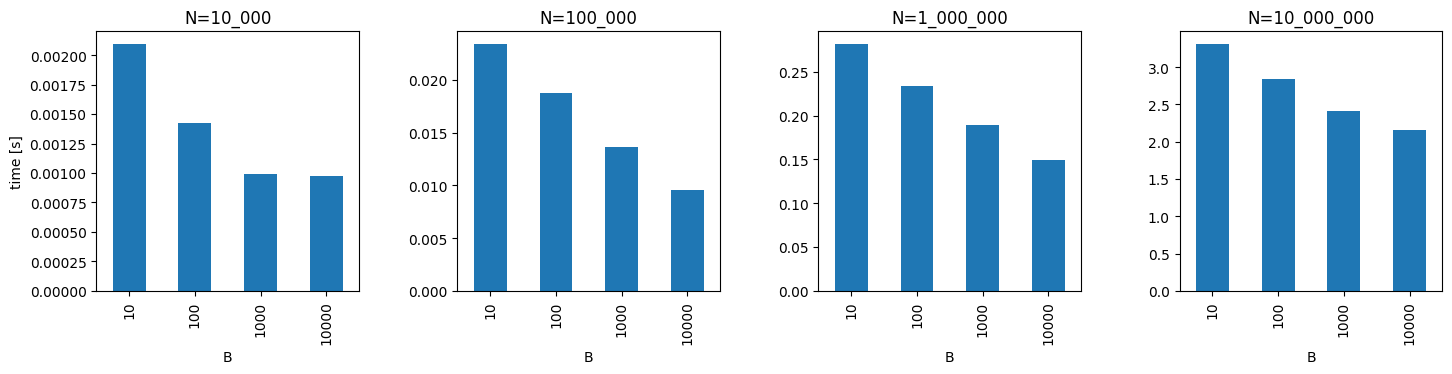

In [124]:
bucket_sort_df = bucket_sort_df.reset_index()
fig, ((ax1, ax2, ax3, ax4)) = plt.pyplot.subplots(1, 4)
fig.set_size_inches(15, 4)
fig.tight_layout(pad=4.0)

ax = bucket_sort_df.loc[bucket_sort_df['N'] == 10_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax1,legend=None, title="N=10_000", ylabel="time [s]")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 100_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax2,legend=None, title="N=100_000")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 1_000_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax3,legend=None, title="N=1_000_000")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 10_000_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax4,legend=None, title="N=10_000_000")

Zwiększanie liczby kubełków zmniejszyło czas sortowania dla każdego rozmiaru problemu.

### B2. Rozkład generatora liczb losowych

Przy użyciu generator liczb losowych `erand48` wygenerowano i zapisano do pliku 1 000 000 wartości. Następnie narysowano histogram uzyskanych wartości dla 10 przedziałów (kolor czerwony) oraz 100 przedziałów (kolor niebieski).

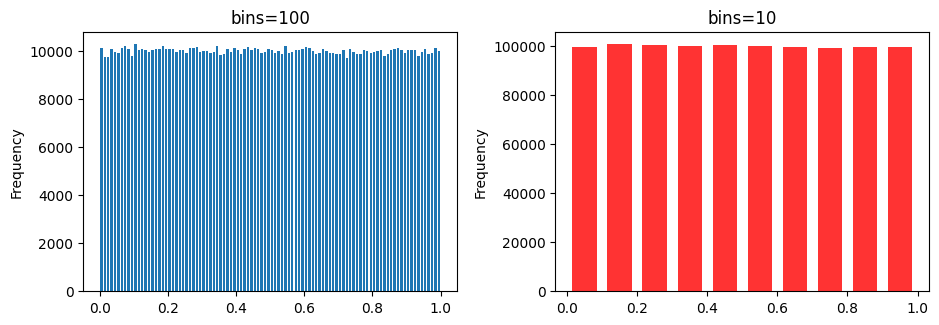

In [125]:
erand48_df = pd.read_csv("erand48_test.csv")

fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=4.0)

_ = erand48_df.plot.hist(ax=ax1, bins=100, rwidth=.7, legend=None, title='bins=100')
_ = erand48_df.plot.hist(ax=ax2, bins=10, rwidth=.7, legend=None, color='red', alpha=0.8, title='bins=10')

Generator `erand48` losuje wartości równomiernie z całego przedziału [0.0, 1.0).

## C. Badanie jakości algorytmów równoległych

Pomiarów dokonano na maszynie Ares. Wykonano po 20 pomiarów dla różnych wielkości problemu (10 000, 100 000, 1 000 000, 10 000 000), rozmiarów koszyka (10, 100, 1 000, 10 000) i liczby proceserów (1, 2, 3, 4). Wyniki dla każdej konfiguracji uśredniono.

In [126]:
bucket_sort_ver_1 = pd.read_csv("bucket_sort_ver_1.csv")
bucket_sort_ver_1.insert(loc=0, column='algorithm ver.', value=1)

bucket_sort_ver_2 = pd.read_csv("bucket_sort_ver_2.csv")
bucket_sort_ver_2.insert(loc=0, column='algorithm ver.', value=2)

df = bucket_sort_ver_1.merge(bucket_sort_ver_2, how='outer')
df = df[['algorithm ver.', 'N', 'B', 'P', 'T_A', 'T_B', 'T_C', 'T_D', 'T_E']].groupby(by=['algorithm ver.', "N", "B", "P"]).mean().reset_index()

### C1. Czas sortowania w zależności od liczby procesorów

In [127]:
def plot_total_time(df, P, ax):
  return df.loc[(df['P'] == P) & (df['N'] == 10_000_000) & (df['B'] == 10_000)][['algorithm ver.', 'T_E']].set_index('algorithm ver.').plot.bar(ax=ax, stacked=True, title=f'{P=}', ylim=(0, 2.5), position=1, width=0.2, color='y')

def plot_compontents_time(df, P, ax):
  return df.loc[(df['P'] == P) & (df['N'] == 10_000_000) & (df['B'] == 10_000)][['algorithm ver.', 'T_A', 'T_B', 'T_C', 'T_D']].set_index('algorithm ver.').plot.bar(ax=ax, stacked=True, legend='reverse', ylim=(0, 2.5), position=0, width=0.2)

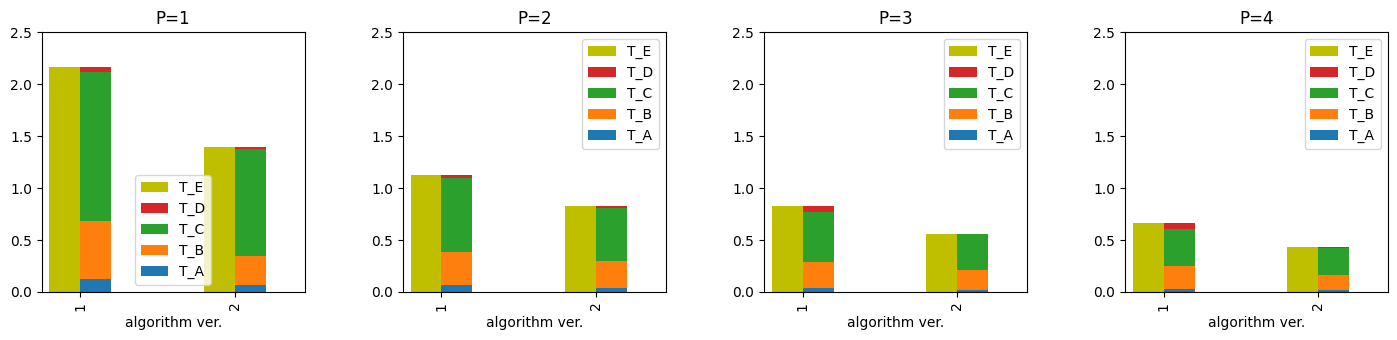

In [128]:
fig, axs = plt.pyplot.subplots(1, 4)
fig.set_size_inches(15, 4)
fig.tight_layout(pad=4.0)

for p in range(4):
  plot_total_time(df, p+1, axs[p])
  plot_compontents_time(df, p+1, axs[p])

### C2. Przyspieszenie w zależności od liczby procesorów

In [129]:
df_1 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 10_000) & (df['algorithm ver.'] == 1)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_1.iloc[0][value]
  df_1[f"speedup_{value}"] = value_1 / df_1[value]
df_1.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
60,1,10000000,10000,1,0.124491,0.560401,1.433030,0.042834,2.160757,1.000000,1.000000,1.000000,1.000000,1.000000
61,1,10000000,10000,2,0.062637,0.321467,0.715726,0.024330,1.124159,1.987500,1.743264,2.002204,1.760588,1.922109
62,1,10000000,10000,3,0.041241,0.247598,0.478074,0.057090,0.824004,3.018594,2.263349,2.997503,0.750300,2.622265
63,1,10000000,10000,4,0.031131,0.214602,0.357758,0.056500,0.659992,3.998954,2.611352,4.005579,0.758126,3.273916


In [130]:
df_2 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 10_000) & (df['algorithm ver.'] == 2)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_2.iloc[0][value]
  df_2[f"speedup_{value}"] = value_1 / df_2[value]
df_2.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
64,2,10000000,10000,1,0.064822,0.278553,1.027202,0.025605,1.396182,1.000000,1.000000,1.000000,1.000000,1.000000
65,2,10000000,10000,2,0.033282,0.261523,0.514055,0.012840,0.821700,1.947670,1.065117,1.998232,1.994243,1.699139
66,2,10000000,10000,3,0.022568,0.187723,0.342655,0.008595,0.561542,2.872320,1.483850,2.997773,2.978974,2.486338
67,2,10000000,10000,4,0.017179,0.147676,0.256979,0.006495,0.428329,3.773341,1.886243,3.997222,3.942297,3.259605
68,2,10000000,10000,5,0.013941,0.120463,0.205786,0.005226,0.345416,4.649879,2.312351,4.991607,4.899349,4.042035


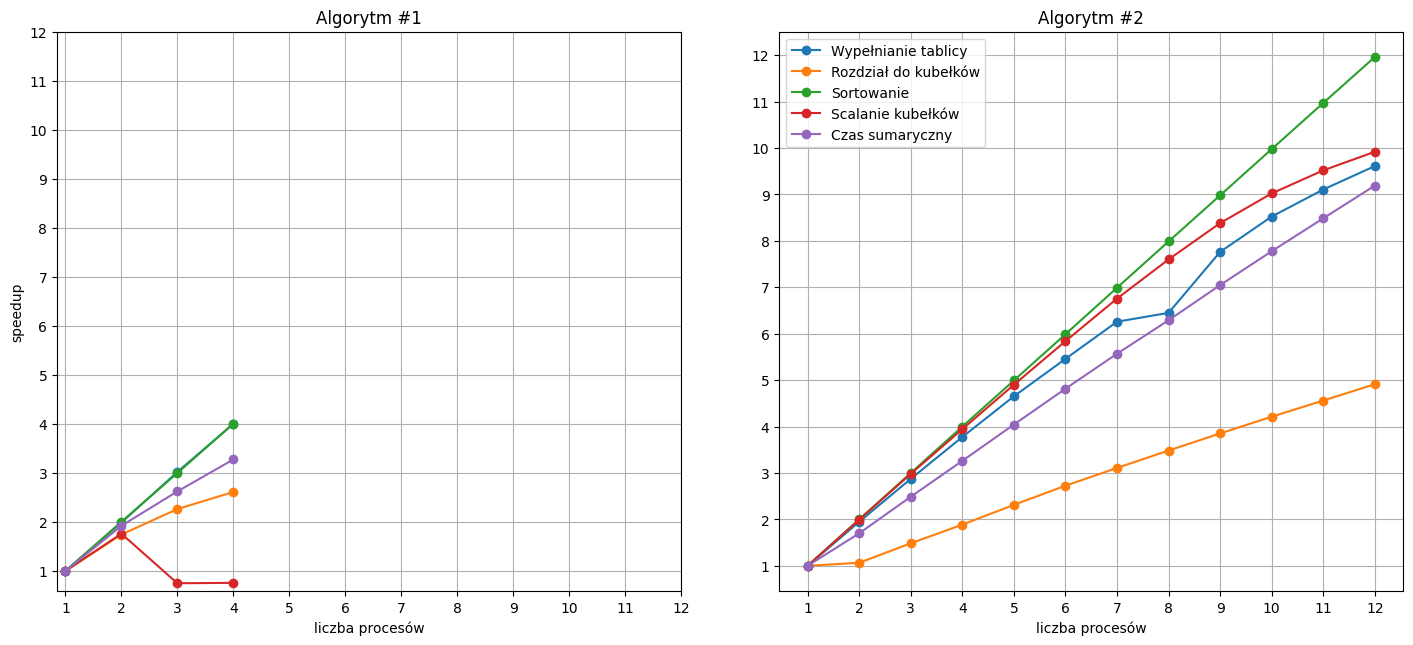

In [131]:
fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(15, 7)
fig.tight_layout(pad=4.0)

common_config = {'linestyle': '-', 'marker': 'o', 'x': 'P', 'xticks':range(1, 13, 1), 'yticks':range(1, 13, 1), 'grid':'both'}
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_1.plot(ax=ax1, y=y, **common_config, title='Algorytm #1', ylabel="speedup", xlabel="liczba procesów", legend=None)
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_2.plot(ax=ax2, y=y, **common_config, title='Algorytm #2', xlabel="liczba procesów")
plt.pyplot.legend(['Wypełnianie tablicy', 'Rozdział do kubełków', 'Sortowanie', 'Scalanie kubełków', 'Czas sumaryczny']);

W obu algorytmach udało się uzyskać przyspieszenie liniowe dla części A (wypełnienie tablicy początkowej liczbami losowymi) oraz C (sortowanie kubełków).

W algorytmie 1. najgorzej wypada część D (przepisania posortowanych kubełków do tablicy początkowej), ponieważ zawiera ona czas synchronizacji wątków z poprzedniego bloku i przepisanie kubełków do tablicy. Słabe wartości przyspieszenia są również dla sekcji B (rozdział liczb do kubełków), co może wynikać z wzajemnego blokowania się watków przy próbie odczytu tablicy. Jednak ostatecznie, przyspieszenie całego algorytmu dla 4 wątków jest lepsze niż dla drugie algorytmu.

W algorytmie 2. udało się uzyskać przypieszenie liniowe również dla części D (przepisania posortowanych kubełków do tablicy początkowej). Ujemne wartości przyspieszenia uzyskano dla części B (rozdział liczb do kubełków). Jest to spowodane źle skonstruowaną sekcją krytyczną:
```c
void add_to_bucket(float** buckets, int* bucket_ind, float val){
    int number_of_bucket = (int) B*val;
    #pragma omp critical
    {
        int number_of_elements_in_bucket = bucket_ind[number_of_bucket];
        buckets[number_of_bucket][number_of_elements_in_bucket] = val;
        bucket_ind[number_of_bucket]++;
    }
}
```
Słabe wartości przyspieszenia dla częsci B mocno rzutują na wartość przyspieszenia całego algorytmu - trochę ponad 2.0 przy 4 wątkach.
